<a href="https://colab.research.google.com/github/JonMcEntee/hm-fashion-recommendations/blob/main/H%26M_Fashion_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
!pip install implicit

In [209]:
%load_ext cudf.pandas
from datetime import datetime, timedelta
from functools import partial
from implicit.als import AlternatingLeastSquares

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import implicit

random_seed = 42

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [3]:
# Mount into drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# H&M Fashion Recommendations

This notebook details my approach to Kaggle's [H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview) competition, focused on predicting customers' next fashion purchases. With vast product selections becoming standard in retail, delivering precisely tailored suggestions is key to enhancing shopping experiences and brand loyalty in modern fashion commerce.

# **Data Loading and Preprocessing**

**Key Data Files**  

1. **`articles.csv`**  
   - Contains detailed metadata for **105,542 unique fashion articles**, including:  
     - `article_id`: Unique identifier for each product.  
     - `product_code`, `prod_name`: Product identifiers and descriptions.  
     - `product_type_no`, `product_type_name`: Numerical and textual product categories.  
     - `product_group_name`: Broad category (e.g., "Garment Upper body").  
     - Visual attributes: `colour_group_name`, `perceived_colour_value_name`, `perceived_colour_master_name`

2. **`customers.csv`**  
   - Profiles **1,371,980 unique customers** with:  
     - `customer_id`: Unique identifier.  
     - `FN` (binary): Indicates if the customer subscribed to H&M’s fashion news.  
     - `Active` (binary): Customer activity status.  
     - `club_member_status`: Loyalty program status.  
     - `fashion_news_frequency`: Categorical. Level of engagement with H&M’s newsletters.  
     - `age`: Customer age.
     - `postal_code`: Location data.

3. **`transactions_train.csv`**  
   - Records **31,788,324 historical transactions** (Sept 2018–Sept 2020) with:  
     - `t_dat`: Transaction date.  
     - `customer_id`: Links to `customers.csv`.  
     - `article_id`: Links to `articles.csv`.  
     - `price`: Purchase price.
     - `sales_channel_id`: Online (1) vs. in-store (2) purchases.  
4. **`images/*.jpg`**
     - **105,104** jpeg images
      - images of each product (potential for computer vision analysis)


In [84]:
articles = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("./drive/My Drive/h-and-m-personalized-fashion-recommendations/transactions_train.csv",
                           parse_dates=['t_dat'])

# Exploratory Data Analysis

To understand purchasing trends, I merged transaction data with article details (product type and group) and analyzed the distribution of sales across different product categories.  

In [ ]:
article_details = pd.merge(transactions,
                           articles[["article_id",
                                     "product_type_name",
                                     "product_group_name"]],
                           how="left", on="article_id")

product_types = article_details.groupby("product_type_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

product_groups = article_details.groupby("product_group_name")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name='count')

del article_details

The bar plot below highlights the top 40 product types by sales volume. Trousers dominate, followed by other upper-body garments like T-shirts and sweaters. This insight can guide inventory prioritization and recommendation strategies.

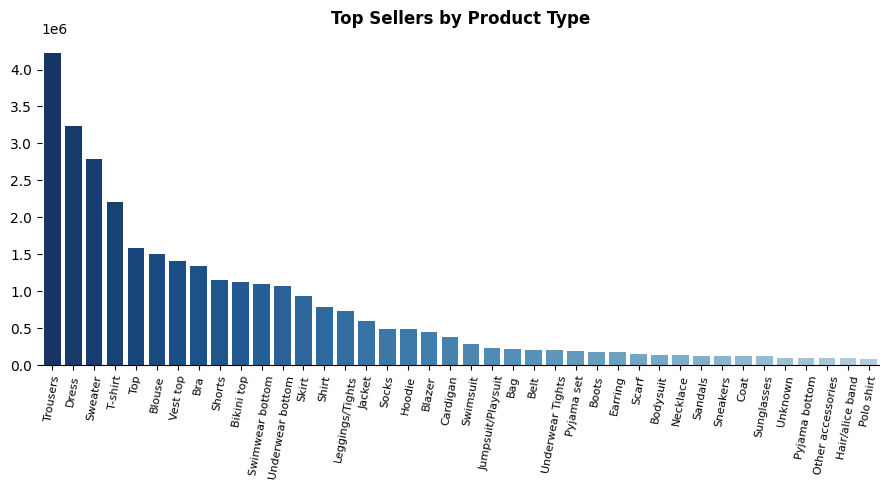

In [ ]:
plt.figure(figsize=(9, 5))
num_categories=40
custom_palette = sns.color_palette('Blues', num_categories + 20)[20:][::-1]
g = sns.barplot(
    product_types.head(num_categories),
    x = "product_type_name",
    y = "count",
    hue="product_type_name",
    palette=custom_palette,
    dodge=False)

g.tick_params(axis='x', labelrotation=80, labelsize=8)

g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Type", fontweight='bold', pad=10)
sns.despine(left=True)
plt.tight_layout()

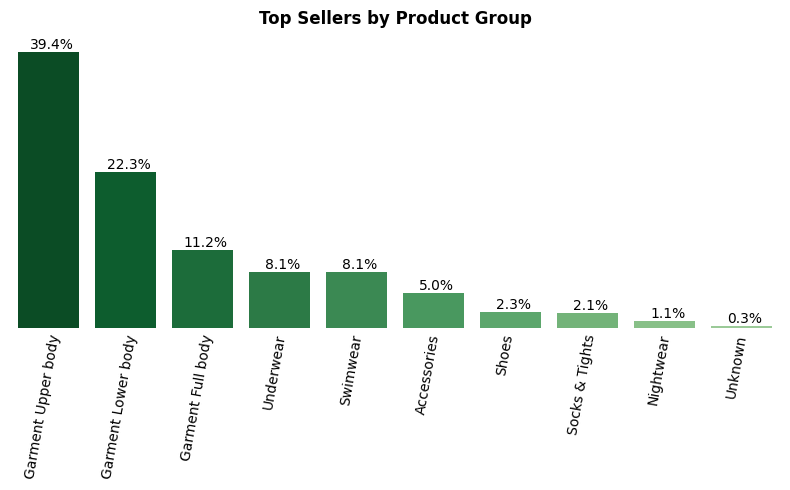

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=10
custom_palette = sns.color_palette('Greens', num_categories + 6)[6:][::-1]
g = sns.barplot(product_groups.head(num_categories), x = "product_group_name", y = "count", hue="product_group_name", palette=custom_palette)

total = product_groups['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=10)

g.tick_params(axis='x', labelrotation=80, labelsize=10, size=0);
shift_amount = -0.07
new_xticks = [x + shift_amount for x in g.get_xticks()]
g.set_xticks(new_xticks)

g.set_xlabel("")
g.set_ylabel("")
g.set_title("Top Sellers by Product Group", fontweight='bold', pad=10)
g.axes.yaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.tight_layout()

Purchase volume over time appears relatively stable, showing no clear upward or downward trend.

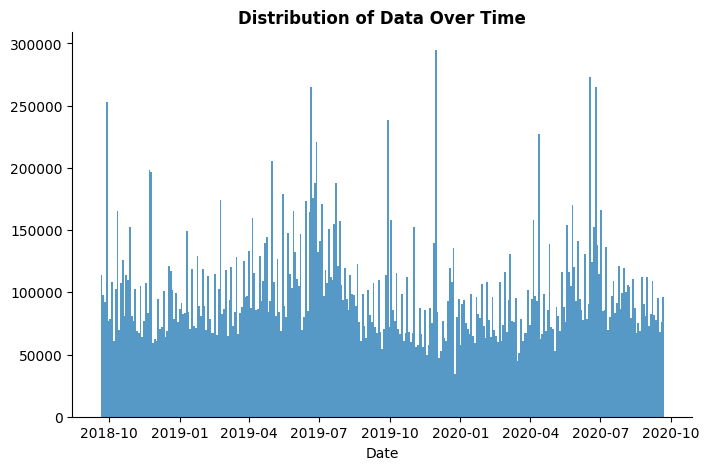

In [ ]:
plt.figure(figsize=(8, 5))
g = sns.histplot(transactions,
                 x = "t_dat",
                 edgecolor=None,
                 bins=100)

g.set_ylabel('', labelpad=0)
g.set_xlabel("Date")
g.set_title("Distribution of Data Over Time", fontweight="bold");
# g.tick_params(axis='x', labelrotation=80, labelsize=10);

sns.despine()

The majority of customers in the dataset have made at least one purchase, enabling the development of personalized recommendation models based on past behavior. However, for customers with limited or no transaction history, cold-start strategies (e.g., demographic-based or popularity-based recommendations) will be essential to provide meaningful suggestions.

In [ ]:
transaction_count = transactions\
  .groupby("customer_id")\
  .size()\
  .reset_index(name="count")\
  .groupby("count")\
  .size()\
  .reset_index(name="customers")

no_transactions = customers[
    ~customers["customer_id"].isin(transactions["customer_id"])]

transaction_count = pd.concat([
      pd.DataFrame([{
          "count": 0,
          "customers": len(no_transactions)
      }]),
      transaction_count
    ],
    ignore_index=True
)

bins = [0, 1, 2, 3, 5, 10, 50, 100, 200, np.inf]
labels = ['0', '1', '2', '3-4', '5-9', '10-49', '50-99', '100-199', '200+']

transaction_count['count_bin'] = pd.cut(transaction_count['count'],
                                        bins=bins,
                                        labels=labels,
                                        right=False,
                                        include_lowest=True)

transaction_bins = transaction_count.groupby('count_bin', observed=True)['customers'].sum().reset_index()

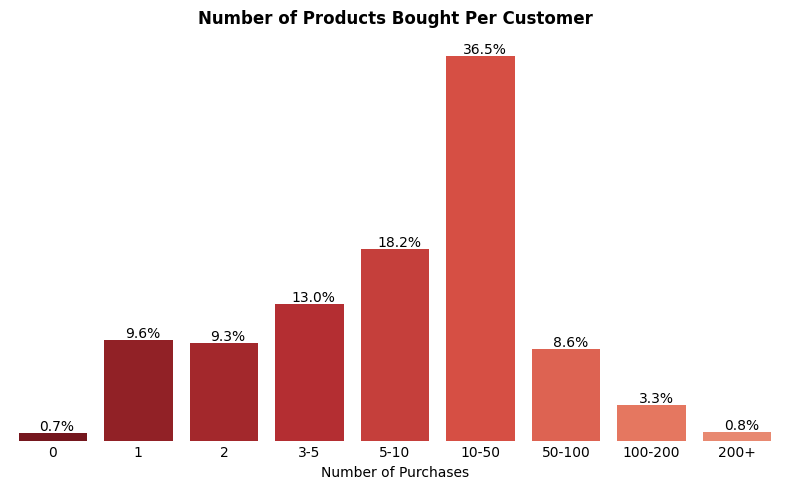

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=len(transaction_bins)
custom_palette = sns.color_palette('Reds', num_categories + 6)[6:][::-1]
g = sns.barplot(transaction_bins,
                x = "count_bin",
                y = "customers",
                hue="count_bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = transaction_bins['customers'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.05,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=10)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Number of Purchases")
g.set_ylabel("Number of Customers")
g.set_title("Number of Products Bought Per Customer", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

 Analysis of the customer age distribution indicates a clear skew toward younger demographics. This trend may reflect H&M’s brand positioning and marketing efforts and should be considered when tailoring recommendation strategies to align with customer preferences.

In [ ]:
age_count = customers.groupby("age").size().reset_index(name="count")

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.inf]
labels = ['16-19', '20-24', '25-29', '30-34', '34-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75+']

age_count["bin"] = pd.cut(age_count["age"],
                          bins=bins,
                          labels=labels,
                          right=False,
                          include_lowest=True)

age_bin = age_count.groupby('bin', observed=True)['count'].sum().reset_index()

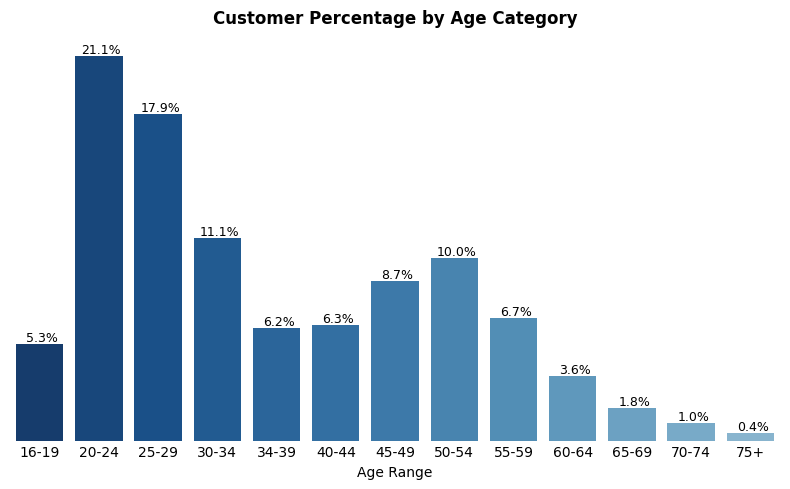

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=len(age_bin)
custom_palette = sns.color_palette('Blues', num_categories + 10)[10:][::-1]
g = sns.barplot(age_bin,
                x = "bin",
                y = "count",
                hue="bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = age_bin['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=9)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Age Range")
g.set_ylabel("Number of Purchases")
g.set_title("Customer Percentage by Age Category", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

This age-related trend extends to purchasing behavior, where younger customers also account for a higher percentage of total transactions. Models may benefit from age-group segmentation to enhance prediction accuracy by capturing generational shopping patterns.

In [ ]:
customer_purchases = pd.merge(transactions,
                              customers,
                              how="left", on="customer_id")

bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, np.inf]
labels = ['16-19', '20-24', '25-29', '30-34', '34-39', '40-44', '45-49',
          '50-54', '55-59', '60-64', '65-69', '70-74', '75+']

customer_purchases["bin"] = pd.cut(customer_purchases["age"],
                                   bins=bins,
                                   labels=labels,
                                   right=False,
                                   include_lowest=True)

purchase_bin = customer_purchases.groupby('bin', observed=True).size().reset_index(name="count")

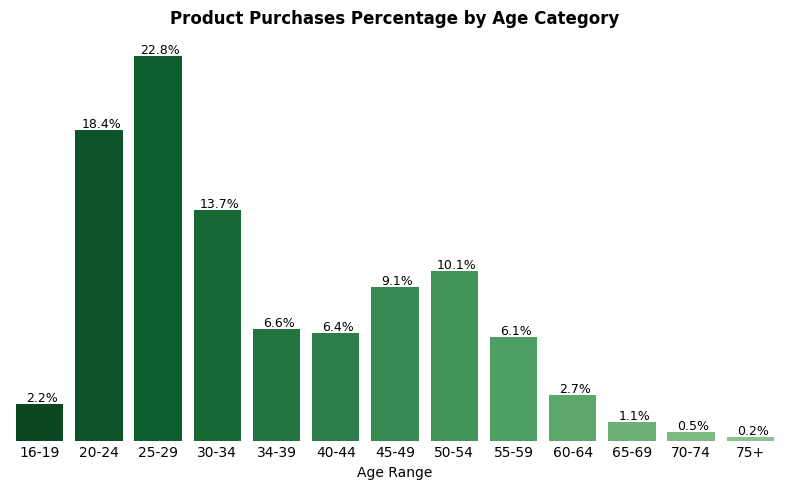

In [ ]:
plt.figure(figsize=(8, 5))
num_categories=len(purchase_bin)
custom_palette = sns.color_palette('Greens', num_categories + 10)[10:][::-1]
g = sns.barplot(purchase_bin,
                x = "bin",
                y = "count",
                hue="bin",
                palette=custom_palette)
g.tick_params(axis='x', labelsize=10, length=0);

total = purchase_bin['count'].sum()

for p in g.patches:
    height = p.get_height()
    percentage = '{:.1f}%'.format(100 * height/total)
    g.text(p.get_x() + p.get_width()/2. + 0.04,
           height,
           percentage,
           ha='center',
           va='bottom',
           fontsize=9)

g.axes.yaxis.set_visible(False)
g.set_xlabel("Age Range")
g.set_ylabel("Number of Purchases")
g.set_title("Product Purchases Percentage by Age Category", fontweight='bold', pad=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Baseline Model: Most Popular Items

To establish a reference point for evaluating more advanced recommendation strategies, we start with a straightforward baseline model: recommending the most frequently purchased items. This simple heuristic serves as a sanity check and helps quantify the minimum performance a more sophisticated model should exceed.

Before modeling, we divide the dataset into training and testing subsets. This allows us to simulate a real-world recommendation scenario where predictions are made on unseen data.


In [99]:
# Downsample the DataFrame for improved performance during prototyping
# transactions_sample = transactions.sample(frac=0.01, random_state=random_seed)
# transaction_sample = transactions[transactions.t_dat > '2020-08-21']
transaction_sample = transactions

In [100]:
test_start = datetime(2020, 9, 15) # maybe should be the 16th
train = transactions_sample[transactions_sample.t_dat < test_start].reset_index(drop=True)
test = transactions_sample[transactions_sample.t_dat >= test_start].reset_index(drop=True)

ground_truth = (
  test[["customer_id", "article_id"]]
  .drop_duplicates()
  .groupby('customer_id')['article_id']
  .apply(list)
  .reset_index()
)

ground_truth.columns = ["customer", "purchased"]

validation_start = datetime(2020, 9, 8)
fitset = train[train.t_dat < validation_start].reset_index(drop=True)
validation = train[train.t_dat >= validation_start].reset_index(drop=True)

validation_truth = (
  test[["customer_id", "article_id"]]
  .drop_duplicates()
  .groupby('customer_id')['article_id']
  .apply(list)
  .reset_index()
)

validation_truth.columns = ["customer", "purchased"]

Our baseline model recommends the top-k most frequently purchased articles across all users in the training set. This approach assumes that popularity alone is a good predictor of future purchases.

In [8]:
top = train\
  .groupby("article_id")\
  .size()\
  .sort_values(ascending=False)\
  .reset_index(name="count")\
  .article_id

def baseline(customer, k=12):
  return top.head(k).tolist()

In [9]:
ground_truth = test[["customer_id", "article_id"]]\
 .drop_duplicates()\
 .groupby('customer_id')['article_id']\
 .apply(list)\
 .reset_index()

ground_truth.columns = ["customer", "purchased"]

To evaluate our recommendations, we use Mean Average Precision at 12 (MAP@12), which is aligned with the competition's evaluation metric. It captures both the relevance and ranking of recommended items.

$$\text{MAP}@12 = \frac{1}{U} \sum_{u=1}^{U} \frac{1}{\min(m, 12)} \sum_{k=1}^{12} P(k) \cdot \text{rel}(k)$$

In [73]:
def precisionk(y_pred: list, y_true: list, k: int = 12) -> float:
    """
    Compute precision at cutoff k (P@k).

    Parameters
    ----------
    y_pred : list
        Ordered list of recommended article IDs (ranked by model)
    y_true : list
        Ground truth list of purchased article IDs
    k : int, optional
        Cutoff rank for evaluation, by default 12

    Returns
    -------
    float
        Precision at k: ratio of relevant items in top-k recommendations
    """
    return len(np.intersect1d(y_pred[:k], y_true)) / k


def relevancek(y_pred: list, y_true: list, k: int = 12) -> int:
    """
    Check if item at rank k is relevant (binary indicator).

    Parameters
    ----------
    y_pred : list
        Ordered list of recommended article IDs
    y_true : list
        Ground truth list of purchased article IDs
    k : int, optional
        Specific rank position to check, by default 12

    Returns
    -------
    int
        1 if item at position k is relevant, 0 otherwise
    """
    if k > len(y_pred):
        return 0
    return 1 if y_pred[k-1] in y_true else 0


def apk(y_pred: list, y_true: list, k: int = 12) -> float:
    """
    Compute average precision at k (AP@k).

    Parameters
    ----------
    y_pred : list
        Ordered list of recommended article IDs
    y_true : list
        Ground truth list of purchased article IDs
    k : int, optional
        Maximum rank to consider, by default 12

    Returns
    -------
    float
        Average precision at k, normalized by min(k, num_relevant_items)
    """
    sum_ap = 0.0
    for i in range(1, k+1):
        sum_ap += precisionk(y_pred, y_true, k=i) * relevancek(y_pred, y_true, k=i)
    return sum_ap / min(k, len(y_true))


def mapk(recommender: callable, valid_gt: pd.DataFrame, k: int = 12) -> float:
    """
    Compute mean average precision at k (MAP@k) across multiple users.

    Parameters
    ----------
    recommender : callable
        A function that accepts a list of customer IDs and a cutoff `k`, and
        returns a DataFrame with two columns:
            - 'customer': customer ID
            - 'recommendations': list of top-k recommended article IDs per customer

    valid_gt : pd.DataFrame
        Ground truth DataFrame containing:
            - 'customer': customer ID
            - 'purchased': list of actual purchased article IDs per customer

    k : int, optional
        Cutoff rank for evaluation (i.e., how many top items to consider), by default 12

    Returns
    -------
    float
        Mean Average Precision at k (MAP@k), averaged across all customers.

    Notes
    -----
    This function:
        - Calls the `recommender` to generate top-k recommendations for each customer.
        - Merges recommendations with ground truth data.
        - Computes the Average Precision at k (AP@k) for each customer.
        - Returns the mean of these AP@k scores.
    """
    df = valid_gt.copy()
    df["recommendations"] = df["customer"].apply(recommender)

    df["average_precision"] = df.apply(
        lambda x: apk(x["recommendations"], x["purchased"], k=k),
        axis=1
    )

    return float(df.average_precision.mean())


Applying the most popular items recommender yields a MAP@12 score of approximately `0.0029`. While this performance is relatively low, it provides a meaningful reference point against which more advanced models (e.g., collaborative filtering) can be evaluated.

In [162]:
mapk(baseline, ground_truth)

0.002931079155331001

While our initial baseline recommends globally popular items, it does not account for recency, which can be crucial in dynamic domains like fashion. To address this, we weight transactions by how recent they are, favoring items that were purchased more recently.

We introduce a time-decay factor to weight each transaction inversely by the number of days before the start of the test period:

In [156]:
train["time_decay"] = train["t_dat"].apply(lambda x : 1 / (test_start - x).days)

top_temporal = train\
  .groupby("article_id")["time_decay"]\
  .sum()\
  .sort_values(ascending=False)\
  .reset_index(name="count")\
  .article_id

def temporal_baseline(customer, k=12):
  return top_temporal.head(k).tolist()

The temporal baseline achieves a MAP@12 score of approximately `0.0055`, nearly doubling the score from our original baseline.

In [157]:
mapk(temporal_baseline, ground_truth)

0.005546329992501777

# Collaborative Filtering: Matrix Factorization with ALS

To move beyond popularity-based methods, we turn to Collaborative Filtering using Matrix Factorization via Alternating Least Squares (ALS). This technique models latent relationships between users and items based on historical interaction patterns.

To incorporate time dynamics into ALS, we define a confidence score for each interaction that decreases with the age of the transaction:

$$
c_{\text{user},\text{item}} = \alpha \cdot \sum_{i} \frac{1}{d_i}
$$

Where:
 - $d_i$ is the number of days since transaction $i$.
 - $\alpha$ is a tunable scaling factor.

We prepare the data by mapping customer and article IDs to integer indices, compute confidence scores using time decay, and construct a dense user-item matrix for training the ALS model.

In [196]:
def train_als_model(train, factors, iterations, regularization, alpha):
  user_ids = train['customer_id'].unique()
  item_ids = train['article_id'].unique()

  user_map = {id_: idx for idx, id_ in enumerate(user_ids)}
  item_map = {id_: idx for idx, id_ in enumerate(item_ids)}

  train['user_idx'] = train['customer_id'].map(user_map)
  train['item_idx'] = train['article_id'].map(item_map)

  # Custom confidence formula
  train['time_decay'] = train["t_dat"].apply(lambda x : alpha / (test_start - x).days)

  purchase_counts = train.groupby(['user_idx', 'item_idx'])["time_decay"].sum().reset_index(name='count')

  item_user_matrix = sp.coo_matrix(
      (purchase_counts['count'].astype(np.float32),
        (purchase_counts['user_idx'], purchase_counts['item_idx'])),
      shape=(len(user_map), len(item_map))
  ).todense() + 1.0

  als_model = AlternatingLeastSquares(
      factors=factors,
      regularization=regularization,
      iterations=iterations,
      random_state=random_seed
  )

  als_model.fit(item_user_matrix)

  return als_model, item_user_matrix, user_map, item_map

One challenge with collaborative filtering is the cold start problem. ALS cannot recommend items for users with no historical data. To handle this, we fall back to our `temporal_baseline` model for unseen users.

In [199]:
def als_recommender(customer, als_model, item_user_matrix, user_map, item_map, top_n=12):
    if customer not in user_map:
        return temporal_baseline(customer)

    reverse_item_map = {idx: id_ for id_, idx in item_map.items()}

    user_idx = user_map[customer]
    recommended = als_model.recommend(user_idx, item_user_matrix[user_idx], N=top_n, filter_already_liked_items=False)

    # Map internal item indices back to article_ids
    return [int(reverse_item_map[item_idx]) for item_idx in recommended[0]]

To optimize the performance of our ALS model, we conduct a grid search over several key hyperparameters. This systematic search allows us to evaluate different combinations of model settings and identify those that yield the best recommendation quality, measured using MAP@12.

In [ ]:
results = []
for regularization in [0.1]:
    for factors in [20, 30]:
        for iterations in [5, 10]:
            for alpha in [30, 50, 100, 150]:
                als_model, item_user_matrix, user_map, item_map = train_als_model(
                    fitset, factors, iterations, regularization, alpha
                )
                als_partial = partial(
                    als_recommender,
                    als_model=als_model,
                    item_user_matrix=item_user_matrix,
                    user_map=user_map,
                    item_map=item_map
                )
                result = {
                    "regularization": regularization,
                    "factors": factors,
                    "iterations": iterations,
                    "alpha": alpha,
                    "map12": mapk(als_partial, validation_truth)
                }
                results.append(result)
                print(result)

In [204]:
 pd.DataFrame.from_records(results).sort_values("map12", ascending=False).head(5)

,regularization,factors,iterations,alpha,map12
1,0.1,20,5,50,0.004827
9,0.1,30,5,50,0.004610
2,0.1,20,5,100,0.004598
0,0.1,20,5,30,0.004581
10,0.1,30,5,100,0.004570


Based on the grid search, we retrain the ALS model on the full training dataset.

In [ ]:
als_model, item_user_matrix, user_map, item_map = train_als_model(
    train,
    factors=20,
    iterations=5,
    regularization=0.1,
    alpha=100
)

als_partial = partial(
    als_recommender,
    als_model=als_model,
    item_user_matrix=item_user_matrix,
    user_map=user_map,
    item_map=item_map
)

The tuned ALS model achieves a MAP@12 score of approximately `0.0069`, which outperforms both baseline recommenders.

In [212]:
mapk(als_partial, ground_truth)

0.006685294452492276

# Content-Based Filtering: Deep Neural Netw